In [27]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.test_suite import TestSuite
from evidently.test_preset import DataDriftTestPreset
import warnings
import os


In [5]:

# Replace these with your details
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'
db_port = '5432'
db_name = 'instilit_salary_db'

# Connect to database
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


In [6]:

# Replace 'your_table_name' with your actual table
df = pd.read_sql("SELECT * FROM raw_salaries", con=engine)
df.head()

,job_title,experience_level,employment_type,company_size,company_location,remote_ratio,salary_currency,years_experience,base_salary,bonus,stock_options,total_salary,salary_in_usd,currency,education,skills,conversion_rate,adjusted_total_usd
0,Data Analyst,Mid,Contract,Medium,Germany,0,INR,13,68407.451747,1100,19325,88832.451747,1065.989421,USD,None,None,1.000,88832.451747
1,DevOps Engineer,Mid,Contract,Small,India,100,GBP,9,64193.117775,2194,19164,85551.117775,111216.453107,EUR,None,None,1.100,94106.229552
2,Research Scientist,Lead,None,Medium,Germany,0,EUR,19,136071.842899,3206,12735,152012.842899,167214.127189,EUR,None,None,1.100,167214.127189
3,Software Engr,Lead,Full-time,Large,India,50,INR,7,141850.905335,9594,11158,162602.905335,19512.348640,USD,None,None,1.000,162602.905335
4,Software Engr,Lead,Intern,Large,Germany,100,INR,10,121841.163226,6796,806,129443.163226,1553.317959,INR,None,None,0.012,1553.317959


In [7]:
# Shape and data types
df.shape

(100000, 18)

In [8]:
# Column names and types
df.dtypes

job_title              object
experience_level       object
employment_type        object
company_size           object
company_location       object
remote_ratio            int64
salary_currency        object
years_experience        int64
base_salary           float64
bonus                   int64
stock_options           int64
total_salary          float64
salary_in_usd         float64
currency               object
education              object
skills                 object
conversion_rate       float64
adjusted_total_usd    float64
dtype: object

In [9]:
# Null values count
df.isnull().sum()

job_title                  0
experience_level       20000
employment_type        23984
company_size               0
company_location           0
remote_ratio               0
salary_currency            0
years_experience           0
base_salary                0
bonus                      0
stock_options              0
total_salary               0
salary_in_usd              0
currency                   0
education             100000
skills                100000
conversion_rate            0
adjusted_total_usd         0
dtype: int64

In [10]:
# Count of unique job titles
df['job_title'].value_counts()

job_title
Data Analyst             16857
DevOps Engineer          16764
Research Scientist       16552
Sofware Engneer           5755
Software Engr             5622
Dt Scientist              5574
Softwre Engineer          5574
Data Scienist             5564
ML Engr                   5512
Data Scntist              5499
ML Enginer                5445
Machine Learning Engr     5282
Name: count, dtype: int64

In [11]:
duplicate_count = df.duplicated().sum()
print("Duplicate rows:",duplicate_count)


Duplicate rows: 10100


In [13]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())



Unique values in 'job_title':
job_title
Data Analyst             16857
DevOps Engineer          16764
Research Scientist       16552
Sofware Engneer           5755
Software Engr             5622
Dt Scientist              5574
Softwre Engineer          5574
Data Scienist             5564
ML Engr                   5512
Data Scntist              5499
ML Enginer                5445
Machine Learning Engr     5282
Name: count, dtype: int64

Unique values in 'experience_level':
experience_level
Mid       20079
Senior    20063
Lead      19944
Junior    19914
Name: count, dtype: int64

Unique values in 'employment_type':
employment_type
Part-time    19146
Full-time    19129
Contract     18901
Intern       18840
Name: count, dtype: int64

Unique values in 'company_size':
company_size
Small     33538
Medium    33469
Large     32993
Name: count, dtype: int64

Unique values in 'company_location':
company_location
UK         17087
Remote     16704
USA        16630
Canada     16558
India      16511


In [14]:
# Summary stats for numerical features
df.describe()

,remote_ratio,years_experience,base_salary,bonus,stock_options,total_salary,salary_in_usd,conversion_rate,adjusted_total_usd
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,1.000000e+05
mean,49.900000,10.010730,2.739155e+05,5000.533550,15014.530770,105189.402427,1.033400e+05,0.833410,2.451668e+05
std,40.727222,6.058082,6.098245e+05,2891.501293,8664.142702,36335.187042,1.461287e+05,0.446652,5.918202e+05
min,0.000000,0.000000,-3.443372e+02,0.000000,0.000000,13732.470754,2.210069e+02,0.012000,1.647896e+02
25%,0.000000,5.000000,5.913957e+04,2508.000000,7463.750000,74890.960608,4.833807e+04,0.750000,4.949571e+04
50%,50.000000,10.000000,9.292292e+04,5004.000000,14995.000000,105372.474677,9.129188e+04,1.000000,9.518815e+04
75%,100.000000,15.000000,1.260539e+05,7504.250000,22530.000000,135233.162454,1.333567e+05,1.100000,1.430316e+05
max,100.000000,20.000000,3.121412e+06,9999.000000,29998.000000,196335.838926,2.354698e+06,1.300000,4.108340e+06


In [15]:
# Summary for categorical columns
df.describe(include='object')

,job_title,experience_level,employment_type,company_size,company_location,salary_currency,currency,education,skills
count,100000,80000,76016,100000,100000,100000,100000,0,0
unique,12,4,4,3,6,5,5,0,0
top,Data Analyst,Mid,Part-time,Small,UK,GBP,GBP,NaN,NaN
freq,16857,20079,19146,33538,17087,20197,20202,NaN,NaN


In [16]:
# Unique values in categorical columns
df.select_dtypes(include='object').nunique()

# Sample unique values for inspection
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col} --> {df[col].unique()[:10]}")



job_title --> ['Data Analyst' 'DevOps Engineer' 'Research Scientist' 'Software Engr'
 'Dt Scientist' 'ML Enginer' 'Data Scienist' 'Data Scntist'
 'Machine Learning Engr' 'ML Engr']

experience_level --> ['Mid' 'Lead' None 'Senior' 'Junior']

employment_type --> ['Contract' None 'Full-time' 'Intern' 'Part-time']

company_size --> ['Medium' 'Small' 'Large']

company_location --> ['Germany' 'India' 'UK' 'Canada' 'USA' 'Remote']

salary_currency --> ['INR' 'GBP' 'EUR' 'CAD' 'USD']

currency --> ['USD' 'EUR' 'INR' 'CAD' 'GBP']

education --> [None]

skills --> [None]


In [17]:
# seeing correlation with target 'adjusted_total_usd'
df.corr(numeric_only=True)['adjusted_total_usd'].sort_values(ascending=False)

adjusted_total_usd    1.000000
base_salary           0.860263
conversion_rate       0.221935
total_salary          0.046865
stock_options         0.013150
salary_in_usd         0.012587
bonus                 0.004132
remote_ratio          0.001564
years_experience     -0.005057
Name: adjusted_total_usd, dtype: float64

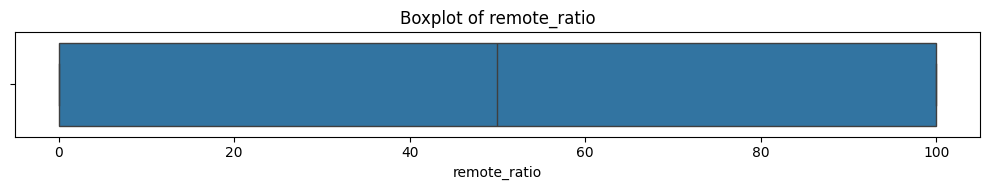

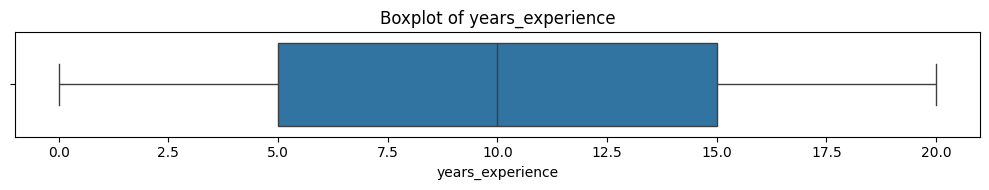

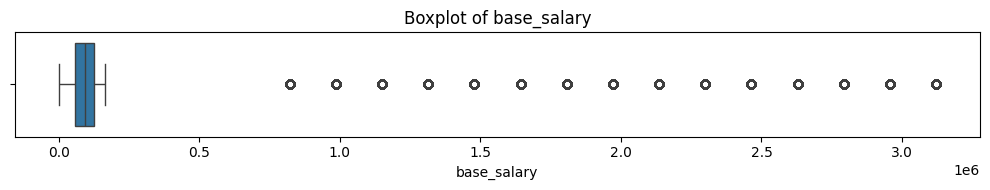

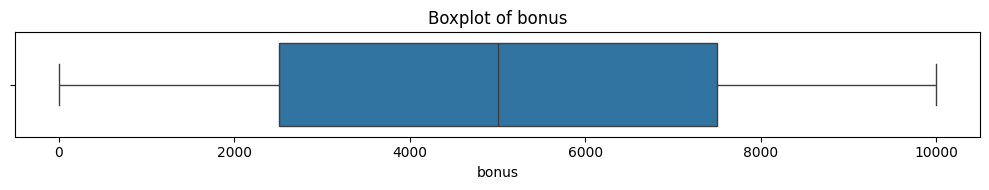

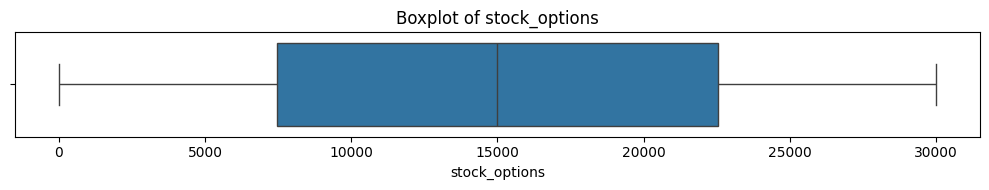

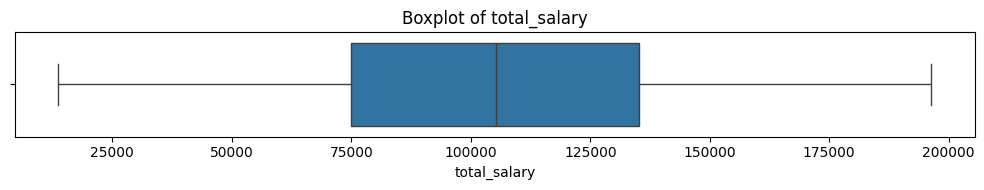

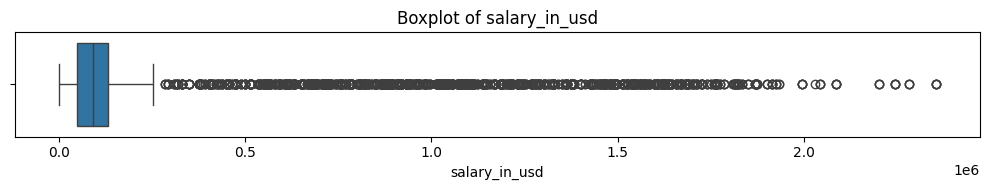

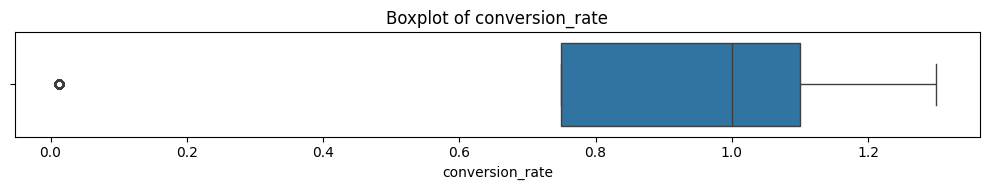

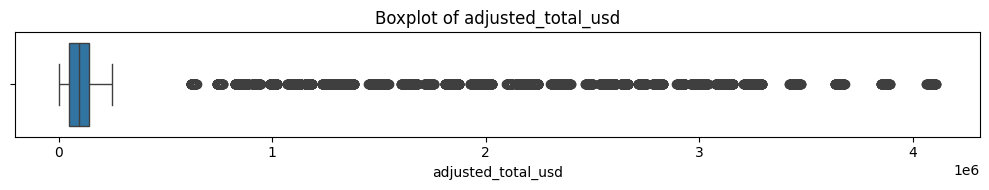

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns and drop columns with all NaNs
numerical_cols = df.select_dtypes(include=['number']).dropna(axis=1, how='all').columns

# Loop through each numeric column
for col in numerical_cols:
    plt.figure(figsize=(10, 2))  # slightly taller to avoid squishing
    sns.boxplot(x=df[col].dropna())  # drop NaNs to avoid issues
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


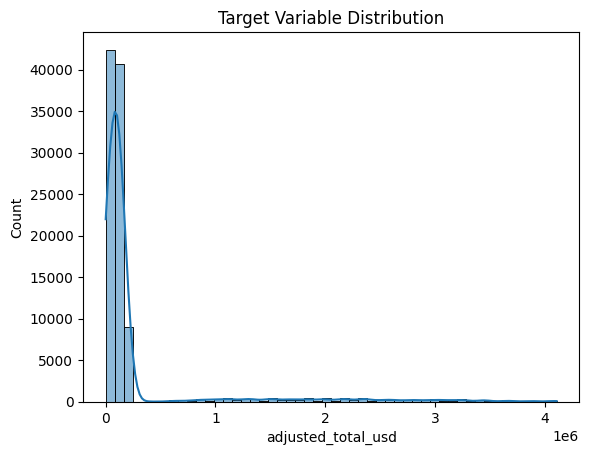

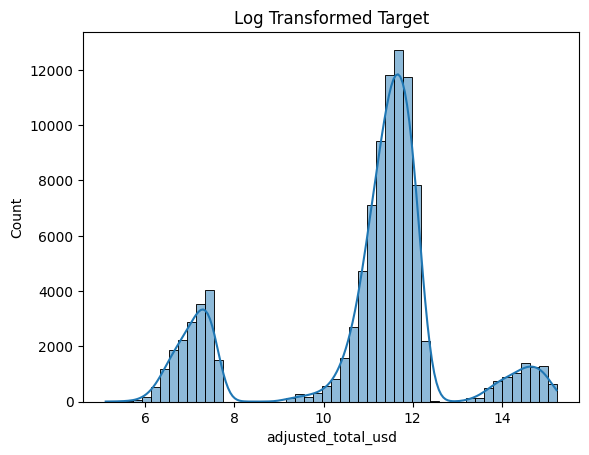

In [23]:
sns.histplot(df['adjusted_total_usd'], bins=50, kde=True)
plt.title("Target Variable Distribution")
plt.show()

# Try log scale
sns.histplot(np.log1p(df['adjusted_total_usd']), bins=50, kde=True)
plt.title("Log Transformed Target")
plt.show()


In [24]:
# Helpful to decide encoding strategy
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")


job_title: 12 unique values
experience_level: 4 unique values
employment_type: 4 unique values
company_size: 3 unique values
company_location: 6 unique values
salary_currency: 5 unique values
currency: 5 unique values
education: 0 unique values
skills: 0 unique values


In [25]:
# For experience_level or employment_type or job_title
df['experience_level'].value_counts(normalize=True) * 100

experience_level
Mid       25.09875
Senior    25.07875
Lead      24.93000
Junior    24.89250
Name: proportion, dtype: float64

In [28]:
# === Drop duplicates ===
df.drop_duplicates(inplace=True)

# === Drop columns with 100% missing ===
df.drop(columns=['education', 'skills'], inplace=True)

# === Fix job title spelling ===
def clean_job_titles(df):
    mapping = {
        'Sofware Engneer': 'Software Engineer',
        'Software Engr': 'Software Engineer',
        'Softwre Engineer': 'Software Engineer',
        'Dt Scientist': 'Data Scientist',
        'Data Scienist': 'Data Scientist',
        'Data Scntist': 'Data Scientist',
        'ML Engr': 'Machine Learning Engineer',
        'ML Enginer': 'Machine Learning Engineer',
        'Machine Learning Engr': 'Machine Learning Engineer',
        'Software Engr': 'Software Engineer',
    }
    df['job_title'] = df['job_title'].replace(mapping)
    df['job_title'] = df['job_title'].str.title().str.strip()
    return df

df = clean_job_titles(df)

# === Handle missing categorical values ===
df['experience_level'] = df['experience_level'].fillna(df['experience_level'].mode()[0])
df['employment_type'] = df['employment_type'].fillna(df['employment_type'].mode()[0])

In [32]:
# === Remove outliers ===
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

numerical_outliers = ['base_salary', 'bonus', 'stock_options', 'adjusted_total_usd']
df = remove_outliers_iqr(df, numerical_outliers)

In [38]:
def univariate_analysis(df):
    # Categorical Columns
    categorical_cols = ['job_title', 'experience_level', 'employment_type', 'company_size', 'company_location']
    
    for col in categorical_cols:
        print(f"\nFrequency for: {col}")
        print(df[col].value_counts())

        plt.figure(figsize=(7, 4))
        sns.countplot(x=col, data=df, palette='Set2', order=df[col].value_counts().index)
        plt.title(f"{col} Distribution")
        plt.xticks(rotation=45)
        plt.show()

    # Numerical Columns
    numerical_cols = ['base_salary', 'bonus', 'stock_options', 'total_salary', 'salary_in_usd', 'adjusted_total_usd', 'years_experience']
    
    for col in numerical_cols:
        print(f"\nStatistics for: {col}")
        print(df[col].describe())

        # Histogram with KDE
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

        # Boxplot
        plt.figure(figsize=(6, 1))
        sns.boxplot(x=df[col], color='orange')
        plt.title(f"Boxplot of {col}")
        plt.show()



📊 Frequency for: job_title
job_title
Software Engineer            14379
Data Scientist               14024
Machine Learning Engineer    13781
Data Analyst                 12692
Devops Engineer              12606
Research Scientist           12434
Name: count, dtype: int64


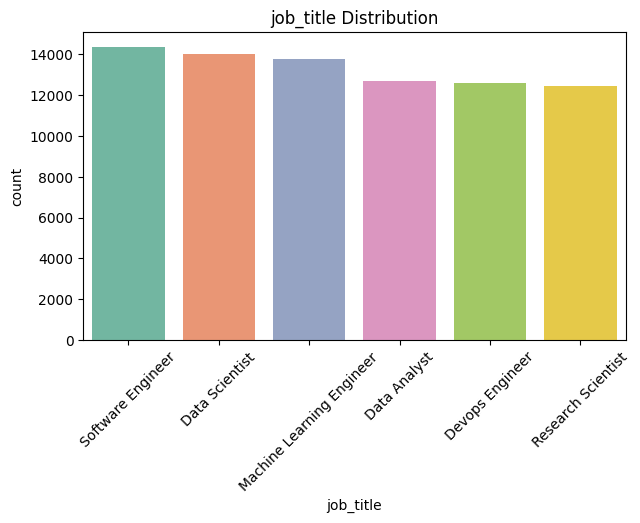


📊 Frequency for: experience_level
experience_level
Mid       27466
Senior    17517
Junior    17479
Lead      17454
Name: count, dtype: int64


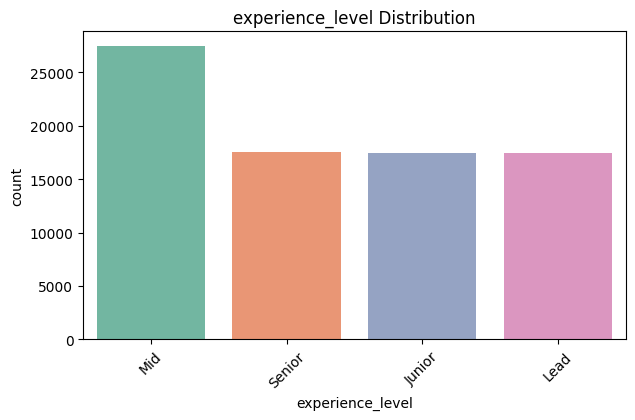


📊 Frequency for: employment_type
employment_type
Part-time    30107
Full-time    16758
Contract     16527
Intern       16524
Name: count, dtype: int64


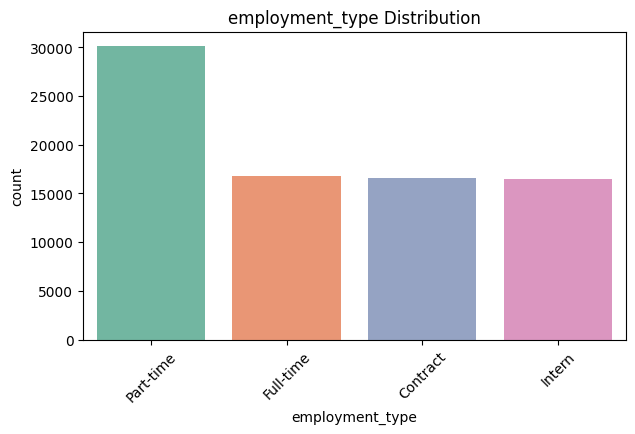


📊 Frequency for: company_size
company_size
Small     26821
Medium    26722
Large     26373
Name: count, dtype: int64


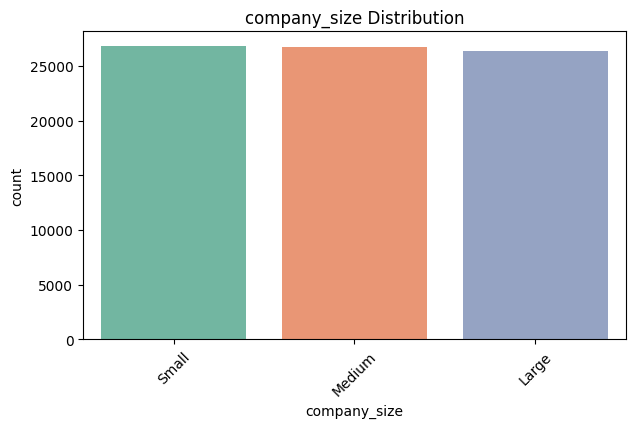


📊 Frequency for: company_location
company_location
UK         13595
Remote     13344
USA        13309
India      13229
Canada     13223
Germany    13216
Name: count, dtype: int64


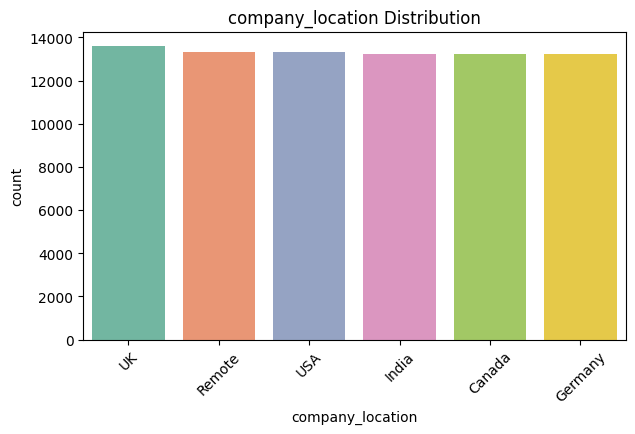


📈 Statistics for: base_salary
count     79916.000000
mean      85088.627527
std       35100.561364
min        -344.337158
25%       55021.291279
50%       85021.789763
75%      115205.258781
max      164284.866357
Name: base_salary, dtype: float64


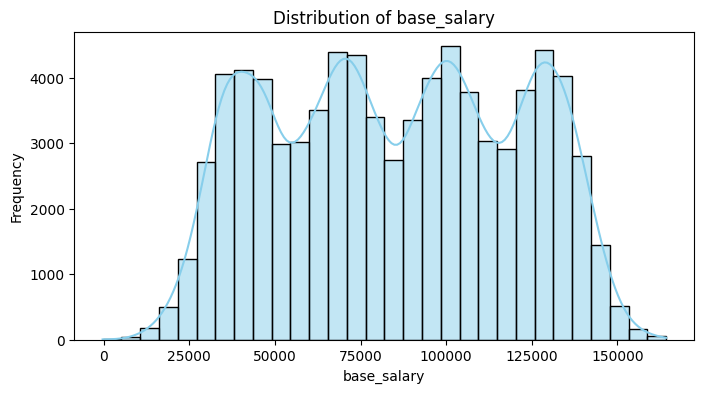

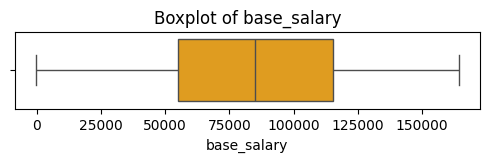


📈 Statistics for: bonus
count    79916.000000
mean      4999.516255
std       2893.244167
min          0.000000
25%       2501.750000
50%       5004.000000
75%       7506.000000
max       9999.000000
Name: bonus, dtype: float64


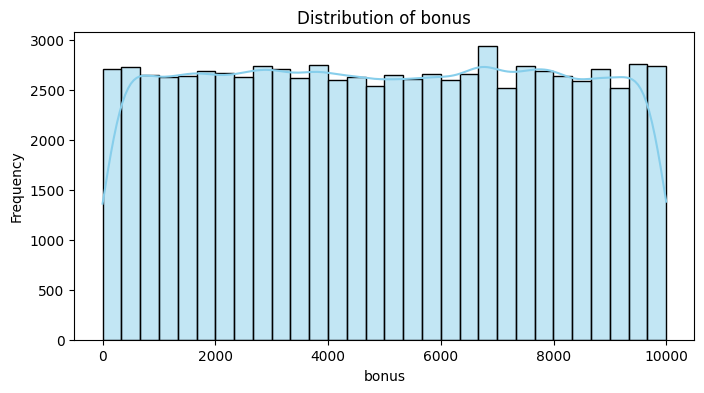

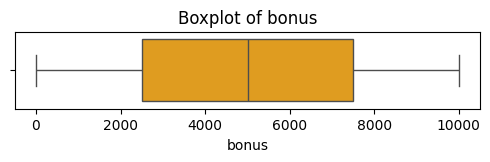


📈 Statistics for: stock_options
count    79916.000000
mean     15014.537352
std       8663.609296
min          0.000000
25%       7464.000000
50%      14993.000000
75%      22522.000000
max      29998.000000
Name: stock_options, dtype: float64


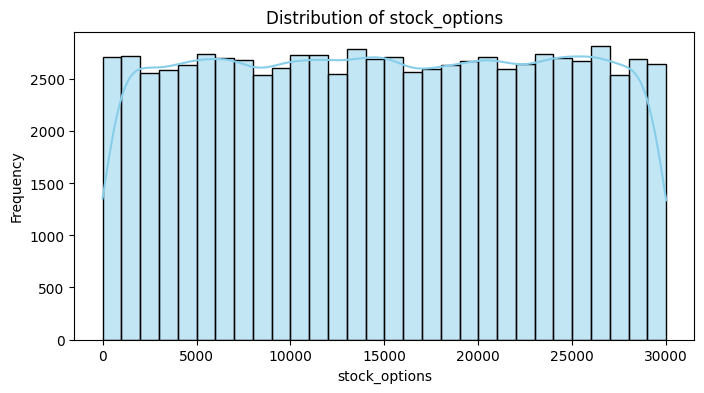

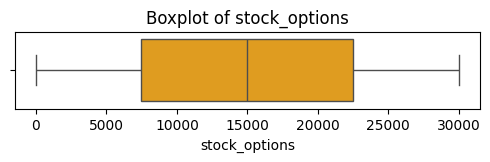


📈 Statistics for: total_salary
count     79916.000000
mean     105102.681133
std       36356.618330
min       13732.470754
25%       74816.251644
50%      105123.243648
75%      135168.740493
max      196335.838926
Name: total_salary, dtype: float64


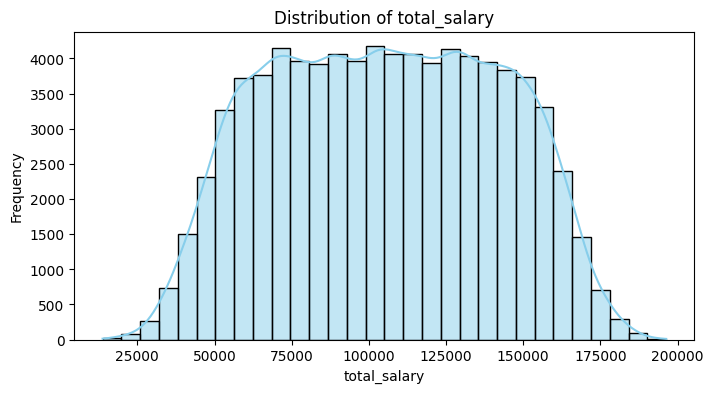

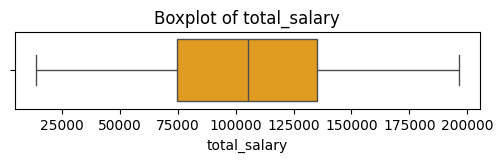


📈 Statistics for: salary_in_usd
count    7.991600e+04
mean     1.034055e+05
std      1.464222e+05
min      2.210069e+02
25%      4.841316e+04
50%      9.119542e+04
75%      1.333329e+05
max      2.354698e+06
Name: salary_in_usd, dtype: float64


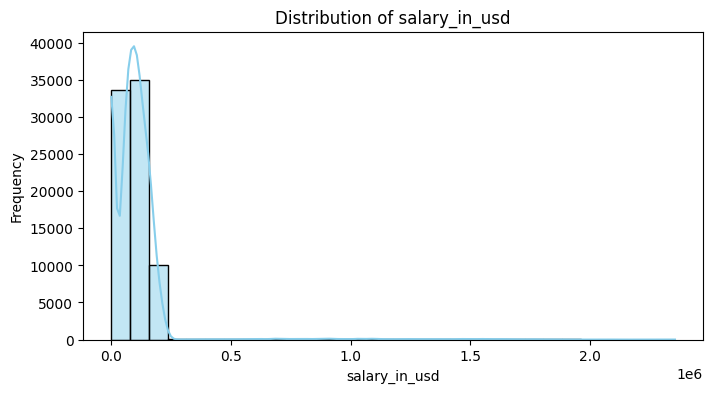

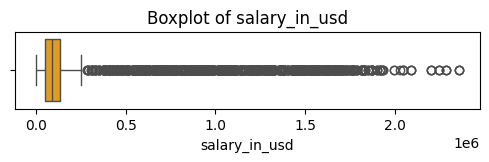


📈 Statistics for: adjusted_total_usd
count     79916.000000
mean      87627.941412
std       58284.508101
min         164.789649
25%       47890.154149
50%       89874.846415
75%      130033.602838
max      251382.620780
Name: adjusted_total_usd, dtype: float64


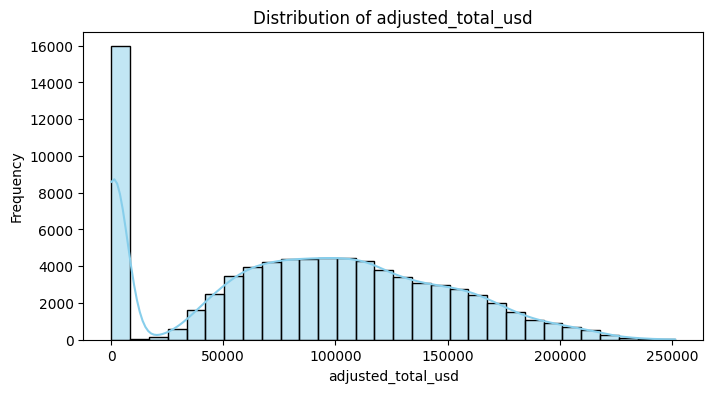

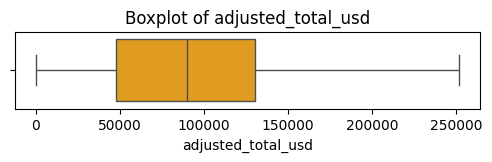


📈 Statistics for: years_experience
count    79916.000000
mean        10.018907
std          6.059572
min          0.000000
25%          5.000000
50%         10.000000
75%         15.000000
max         20.000000
Name: years_experience, dtype: float64


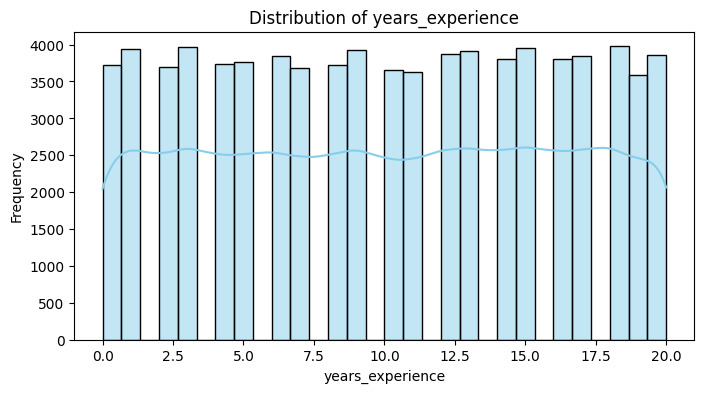

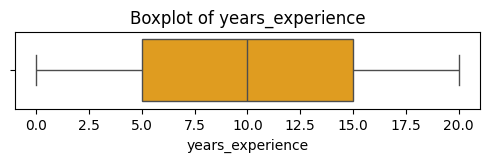

In [39]:
univariate_analysis(df)

In [ ]:
def bivariate_analysis(df, sample_size=5000):
    """
    Performs bivariate analysis on selected pairs of variables.
    Includes log scale and random sampling for better visuals.
    """
    # Sample data for visualization (if dataset is large)
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)

    # 1. Base Salary vs Experience Level
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='experience_level', y='base_salary', data=df, palette='coolwarm')
    plt.yscale('log')  # log scale to reduce skewness
    plt.title("Base Salary by Experience Level (Log Scale)")
    plt.xlabel("Experience Level")
    plt.ylabel("Base Salary (log)")
    plt.show()

    # 2. Base Salary vs Top Job Titles
    top_jobs = df['job_title'].value_counts().head(5).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='job_title', y='base_salary', data=df[df['job_title'].isin(top_jobs)], palette='Set3')
    plt.yscale('log')
    plt.title("Base Salary by Top 5 Job Titles (Log Scale)")
    plt.xlabel("Job Title")
    plt.ylabel("Base Salary (log)")
    plt.xticks(rotation=45)
    plt.show()

    # 3. Adjusted Salary vs Remote Type
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='remote_type', y='adjusted_total_usd', data=df, palette='pastel')
    plt.yscale('log')
    plt.title("Adjusted Salary by Remote Type (Log Scale)")
    plt.xlabel("Remote Type")
    plt.ylabel("Adjusted Salary (log)")
    plt.show()

    # 4. Experience vs Adjusted Salary (Regression)
    plt.figure(figsize=(6, 4))
    sns.regplot(x='years_experience', y='adjusted_total_usd', data=df, scatter_kws={'alpha':0.3})
    plt.yscale('log')
    plt.title("Experience vs Adjusted Salary (Log Scale)")
    plt.xlabel("Years of Experience")
    plt.ylabel("Adjusted Salary (log)")
    plt.show()

In [42]:
def bivariate_analysis(df, sample_size=5000):
    """
    Performs bivariate analysis on selected pairs of variables.
    Includes log scale and random sampling for better visuals.
    """
    # Sample data for visualization (if dataset is large)
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)

    # 1. Base Salary vs Experience Level
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='experience_level', y='base_salary', data=df, palette='coolwarm')
    plt.yscale('log')  # log scale to reduce skewness
    plt.title("Base Salary by Experience Level (Log Scale)")
    plt.xlabel("Experience Level")
    plt.ylabel("Base Salary (log)")
    plt.show()

    # 2. Base Salary vs Top Job Titles
    top_jobs = df['job_title'].value_counts().head(5).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='job_title', y='base_salary', data=df[df['job_title'].isin(top_jobs)], palette='Set3')
    plt.yscale('log')
    plt.title("Base Salary by Top 5 Job Titles (Log Scale)")
    plt.xlabel("Job Title")
    plt.ylabel("Base Salary (log)")
    plt.xticks(rotation=45)
    plt.show()

    # 3. Experience vs Adjusted Salary (Regression)
    plt.figure(figsize=(6, 4))
    sns.regplot(x='years_experience', y='adjusted_total_usd', data=df, scatter_kws={'alpha':0.3})
    plt.yscale('log')
    plt.title("Experience vs Adjusted Salary (Log Scale)")
    plt.xlabel("Years of Experience")
    plt.ylabel("Adjusted Salary (log)")
    plt.show()

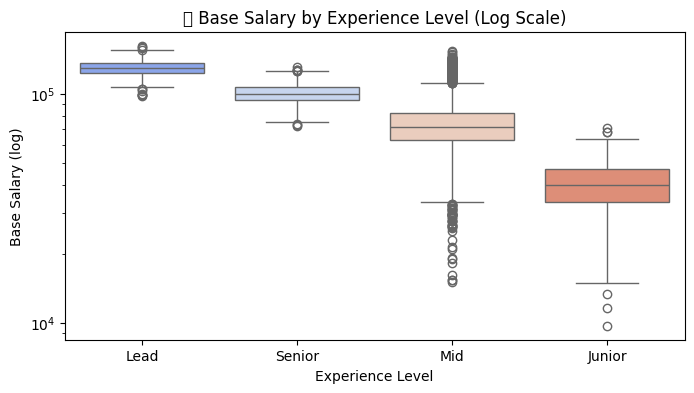

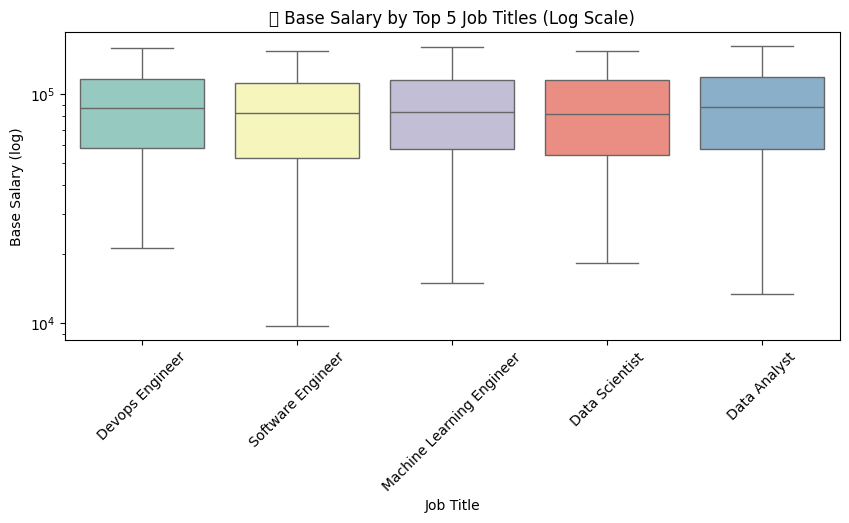

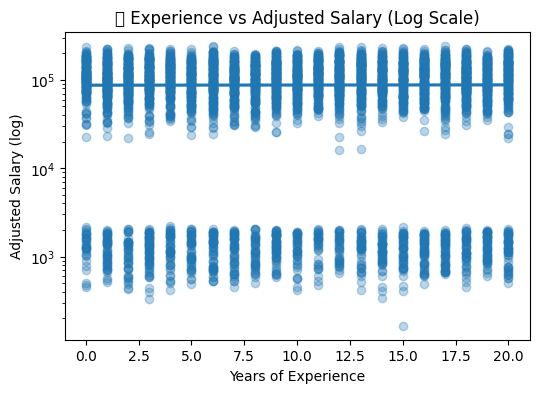

In [43]:
bivariate_analysis(df)

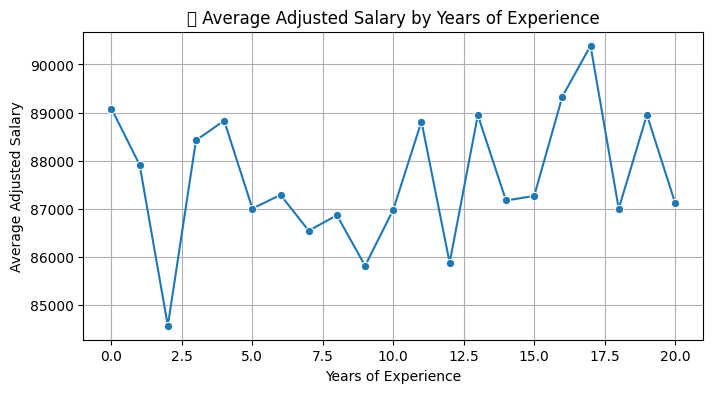

In [45]:
def salary_by_experience_group(df):
    grouped = df.groupby('years_experience')['adjusted_total_usd'].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x='years_experience', y='adjusted_total_usd', data=grouped, marker='o')
    plt.title("Average Adjusted Salary by Years of Experience")
    plt.xlabel("Years of Experience")
    plt.ylabel("Average Adjusted Salary")
    plt.grid(True)
    plt.show()

# Call the function
salary_by_experience_group(df)


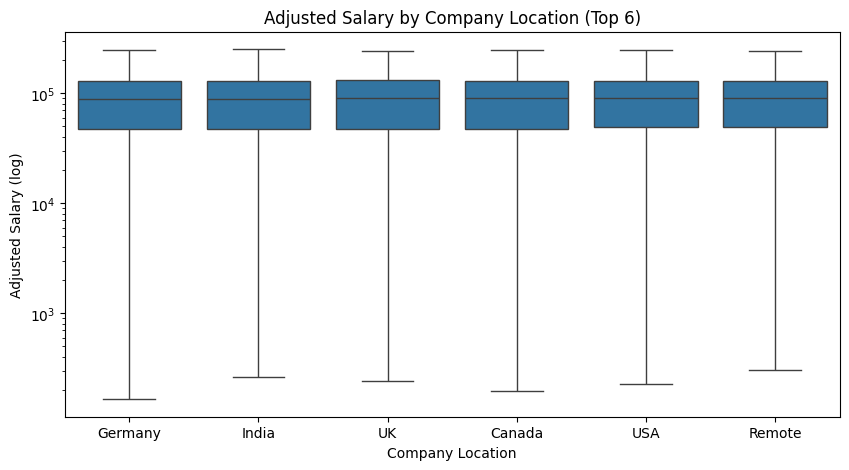

In [47]:
def boxplot_salary_by_country(df):
    top_countries = df['company_location'].value_counts().head(6).index
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='company_location', y='adjusted_total_usd', data=df[df['company_location'].isin(top_countries)])
    plt.yscale('log')
    plt.title("Adjusted Salary by Company Location (Top 6)")
    plt.xlabel("Company Location")
    plt.ylabel("Adjusted Salary (log)")
    plt.show()

# Call the function
boxplot_salary_by_country(df)


In [48]:
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 6))
    corr = df.select_dtypes(include='number').corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Numerical Features")
    plt.show()

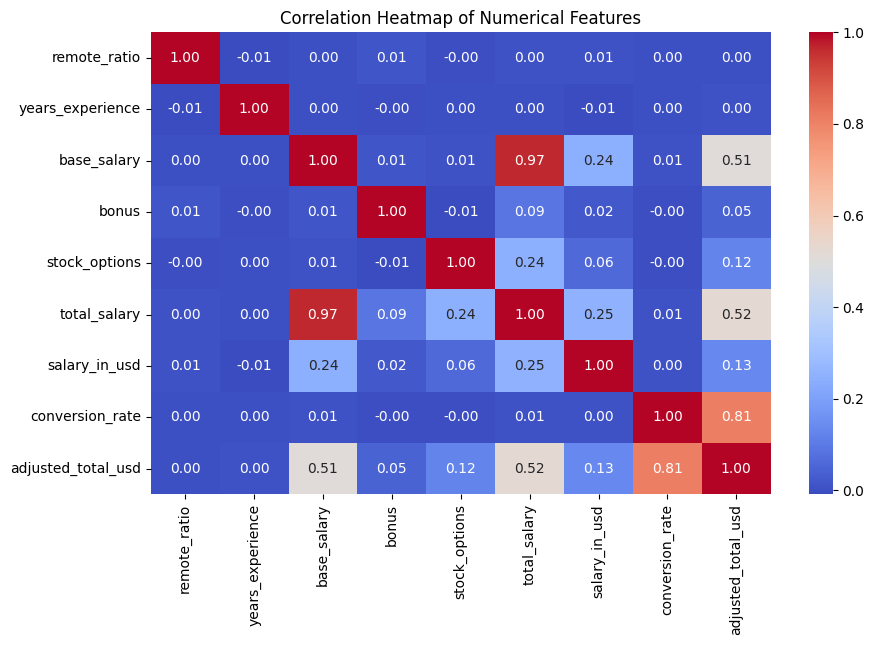

In [49]:
plot_correlation_heatmap(df)

In [50]:
def average_salary_by_job(df, top_n=6):
    avg_salary = df.groupby('job_title')['adjusted_total_usd'].mean().sort_values(ascending=False).head(top_n)
    print("Top Job Titles by Average Adjusted Salary:")
    print(avg_salary)
average_salary_by_job(df)

Top Job Titles by Average Adjusted Salary:
job_title
Devops Engineer              87889.242548
Research Scientist           87883.930724
Machine Learning Engineer    87815.125950
Software Engineer            87631.093415
Data Scientist               87337.506332
Data Analyst                 87231.724545
Name: adjusted_total_usd, dtype: float64


In [51]:
# === Drop leaky columns ===
df.drop(columns=['total_salary', 'salary_in_usd', 'conversion_rate'], inplace=True)

# === Define target ===
TARGET = 'adjusted_total_usd'
X = df.drop(columns=[TARGET])
y = df[TARGET]

# === Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# === Drift Detection Report ===
drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=X_train, current_data=X_test)
drift_html_path = "drift_report_train_vs_test.html"
drift_report.save_html(drift_html_path)

# === Column types ===
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# === Preprocessor ===
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

In [53]:
# === Model definitions ===
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror', random_state=42)
}

mlflow.set_experiment("salary_prediction_pipeline")

best_model = None
best_score = -np.inf
best_pipeline = None

for name, model in models.items():
    with mlflow.start_run(run_name=name) as run:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Save drift report and log as artifact
        drift_artifact_path = "drift_report_train_vs_test.html"
        if os.path.exists(drift_artifact_path):
            mlflow.log_artifact(drift_artifact_path)

        mlflow.sklearn.log_model(pipeline, name)


        print(f"\n🚀 {name} Evaluation:")
        print(f"📉 MSE: {mse:,.2f}")
        print(f"📉 MAE: {mae:,.2f}")
        print(f"📈 R² Score: {r2:.4f}")

        if r2 > best_score:
            best_model = model
            best_pipeline = pipeline
            best_score = r2
            best_name = name

2025/07/06 23:50:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 23:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🚀 LinearRegression Evaluation:
📉 MSE: 270,111,005.85
📉 MAE: 11,293.76
📈 R² Score: 0.9204


2025/07/06 23:51:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 23:51:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🚀 RandomForest Evaluation:
📉 MSE: 7,951,064.86
📉 MAE: 1,946.75
📈 R² Score: 0.9977


2025/07/06 23:51:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 23:51:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🚀 XGBoost Evaluation:
📉 MSE: 912,345.55
📉 MAE: 700.62
📈 R² Score: 0.9997



🧠 SHAP interpretation of best model...


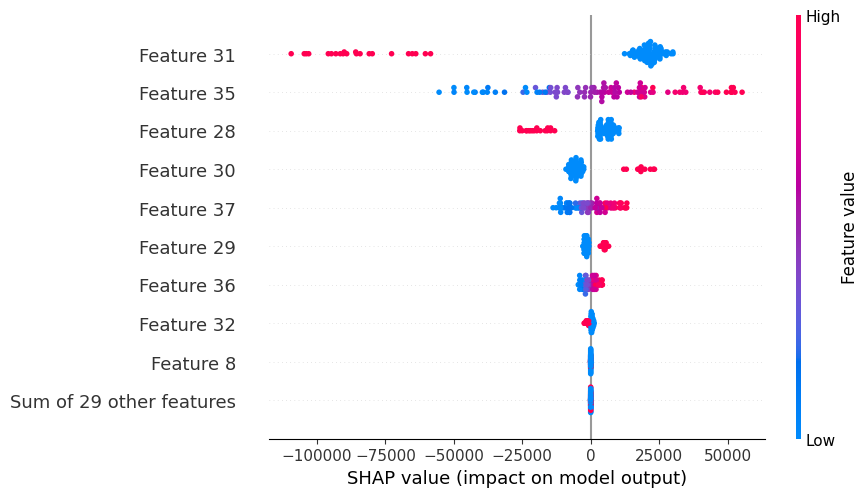

In [54]:
# === SHAP Interpretation ===
print("\n🧠 SHAP interpretation of best model...")
# Only use XGBoost or RandomForest for SHAP
if best_name in ["XGBoost", "RandomForest"]:
    explainer = shap.Explainer(best_pipeline.named_steps['regressor'])
    transformed_X = best_pipeline.named_steps['preprocessor'].transform(X_test)
    shap_values = explainer(transformed_X[:100])  # Limit to 100 samples for speed
    shap.plots.beeswarm(shap_values)
else:
    print("SHAP only supported for tree-based models. Skipping SHAP plot.")

In [55]:
# === Register the best model ===
with mlflow.start_run(run_name=f"Register_{best_name}") as best_run:
    mlflow.sklearn.log_model(
        best_pipeline,
        artifact_path=best_name,
        registered_model_name="Best_Salary_Predictor"
    )
    mlflow.log_metric("best_r2", best_score)
    mlflow.log_artifact(drift_html_path)
    print(f"\n✅ Best model registered: {best_name} with R²: {best_score:.4f}")


2025/07/06 23:52:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 23:52:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✅ Best model registered: XGBoost with R²: 0.9997


Successfully registered model 'Best_Salary_Predictor'.
Created version '1' of model 'Best_Salary_Predictor'.
